# Intermediate Machine Learning

This notebook accompanies the intermediate machine learning course on Kaggle. It is concerned with ways to improve th quality of models using
 * manipulation of different data types, e.g., categorical variables;
 * pipelines;
 * cross-validation;
 * XGBoost;
 * avoiding leakage.

The dataset which will be used contains house prices in Iowa, along with 79 different explanatory variables.

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split

In [5]:
iowa_train_data_dir = "../data/train.csv"
iowa_test_data_dir = "../data/test.csv"

data_full = pd.read_csv(iowa_train_data_dir)
data_full_test = pd.read_csv(iowa_test_data_dir)

y = data_full.SalePrice
features = ['LotArea', 'YearBuilt', '1stFlrSF', '2ndFlrSF', 'FullBath', 'BedroomAbvGr', 'TotRmsAbvGrd']
X = data_full.loc[:, features].copy()
X_test = data_full_test.loc[:, features].copy()

X_train, X_validate, y_train, y_validate = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=0)

We start by considering various different random forest models. Some of the properties of random forests include:
 * number of trees in forest (n_estimators)
 * criterion to measure the quality of a split (criterion)
 * minimum number of samples required to initiate a split (min_samples_split)
 * maximum depth of trees in forest (max_depth)

To determine the best model, we evaluate the MAE for each one on the validation data.

In [6]:
from sklearn.ensemble import RandomForestRegressor

model_1 = RandomForestRegressor(n_estimators=50, random_state=0)
model_2 = RandomForestRegressor(n_estimators=100, random_state=0)
model_3 = RandomForestRegressor(n_estimators=100, criterion='absolute_error', random_state=0)
model_4 = RandomForestRegressor(n_estimators=200, min_samples_split=20, random_state=0)
model_5 = RandomForestRegressor(n_estimators=100, max_depth=7, random_state=0)

models = [model_1, model_2, model_3, model_4, model_5]

In [8]:
from sklearn.metrics import mean_absolute_error

def score_model(model, X_train=X_train, X_validate=X_validate, y_train=y_train, y_validate=y_validate):
    model.fit(X_train, y_train)
    predictions = model.predict(X_validate)
    return mean_absolute_error(y_validate, predictions)

for i, model in enumerate(models):
    print("Model " + str(i) + ": MAE = " + str(round(score_model(model))))


Model 0: MAE = 24015
Model 1: MAE = 23741
Model 2: MAE = 23529
Model 3: MAE = 23997
Model 4: MAE = 23707


It appears that the best model was the one using the absolute error criterion. To find the best model, we shall perform an exhaustive search over the following set of parameters:
 * n_estimators = 50, 100, 150, 200
 * criterion = “squared_error”, “absolute_error”, “poisson”
 * min_samples_split = 10, 20, 40, 80
 * max_depth = 3, 5, 7, 9

In [19]:
import itertools

n_estimators_vals = [50, 100, 150, 200]
criteria = ["squared_error", "absolute_error", "poisson"]
min_samples_split_vals = [2, 4, 6, 8, 10]
max_depth = [3, 5, 7, 9, 11, 13]

parameter_combos = list(itertools.product(n_estimators_vals, criteria, min_samples_split_vals, max_depth))

In [20]:
min_mae = None
best_model = None
best_model_params = None

for combo in parameter_combos:
    tmp_model = RandomForestRegressor(n_estimators=combo[0], criterion=combo[1], min_samples_split=combo[2], max_depth=combo[3], random_state=0)
    tmp_mae = score_model(tmp_model)
    if min_mae == None or tmp_mae < min_mae:
        min_mae = tmp_mae
        best_model = tmp_model
        best_model_params = combo
        print(best_model_params, ": MAE = " + str(round(min_mae)))

(50, 'squared_error', 2, 3) : MAE = 30711
(50, 'squared_error', 2, 5) : MAE = 25769
(50, 'squared_error', 2, 7) : MAE = 23669
(50, 'squared_error', 6, 7) : MAE = 23662
(50, 'squared_error', 8, 7) : MAE = 23660
(50, 'squared_error', 8, 9) : MAE = 23613
(50, 'absolute_error', 2, 7) : MAE = 23451
(50, 'absolute_error', 2, 9) : MAE = 23357
(50, 'absolute_error', 2, 13) : MAE = 23305
(50, 'absolute_error', 4, 11) : MAE = 23300
(100, 'absolute_error', 2, 9) : MAE = 23244
(100, 'absolute_error', 2, 13) : MAE = 23209
(200, 'absolute_error', 2, 9) : MAE = 23141
(200, 'absolute_error', 2, 11) : MAE = 23110


Once we have found the best model, we train it using the full dataset.

In [21]:
final_model = RandomForestRegressor(n_estimators=best_model_params[0], criterion=best_model_params[1], min_samples_split=best_model_params[2], max_depth=best_model_params[3])
final_model.fit(X, y)
predictions_test = final_model.predict(X_test)

output = pd.DataFrame({'Id': data_full_test.Id,
                       'SalePrice': predictions_test})
output.to_csv('submission.csv', index=False)

Up until now we have only considered a subset of the available data when creating our model. We now look into the other available features. However, first we need to determine whether there is missing data in the dataset.

In [30]:
y = data_full.SalePrice
X_full = data_full.drop(['SalePrice', 'Id'], axis=1)
# keep only the numerical variables for now
X = X_full.select_dtypes(exclude=['object'])
X_test = data_full_test.select_dtypes(exclude=['object'])

X_train, X_validate, y_train, y_validate = train_test_split(X, y, train_size = 0.8, test_size = 0.2, random_state=0)

print(X_train.shape)

missing_val_count_by_column = X_train.isnull().sum()
print(missing_val_count_by_column[missing_val_count_by_column > 0])

(1168, 36)
LotFrontage    212
MasVnrArea       6
GarageYrBlt     58
dtype: int64


Out of all the numeric columns in the data, only three contain missing information. Since the counts of missing values is significantly lower than the total number of entries in the data set, we will perform imputation on the data, i.e., set the missing values to the means of the respective columns.

In [34]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer()
imputed_X_train = pd.DataFrame(imputer.fit_transform(X_train))
imputed_X_validate = pd.DataFrame(imputer.transform(X_validate))

imputed_X_train.columns = X_train.columns
imputed_X_validate.columns = X_validate.columns

model = RandomForestRegressor(n_estimators=100, random_state = 0)
model.fit(imputed_X_train, y_train)
predictions_validate_imputed = model.predict(imputed_X_validate)
print("MAE (imputation):", mean_absolute_error(y_validate, predictions_validate_imputed))

MAE (imputation): 18062.894611872147


Alternatively, we can simply drop the columns containing missing information.

In [35]:
columns_missing_info = missing_val_count_by_column[missing_val_count_by_column > 0].index.tolist()

X_train_dropped = X_train.drop(columns_missing_info, axis=1)
X_validate_dropped = X_validate.drop(columns_missing_info, axis=1)

model = RandomForestRegressor(n_estimators=100, random_state = 0)
model.fit(X_train_dropped, y_train)
predictions_validate_dropped = model.predict(X_validate_dropped)
print("MAE (dropped):", mean_absolute_error(y_validate, predictions_validate_dropped))

MAE (dropped): 17837.82570776256


Another option is to perform imputation but also keep track of the variables that are imputed.

In [36]:
X_train_plus = X_train.copy()
X_validate_plus = X_validate.copy()

for col in columns_missing_info:
    X_train_plus[col + "_was_missing"] = X_train_plus[col].isnull()
    X_validate_plus[col + "_was_missing"] = X_validate_plus[col].isnull()

imputer = SimpleImputer()
imputed_X_train_plus = pd.DataFrame(imputer.fit_transform(X_train_plus))
imputed_X_validate_plus = pd.DataFrame(imputer.transform(X_validate_plus))

imputed_X_train_plus.columns = X_train_plus.columns
imputed_X_validate_plus.columns = X_validate_plus.columns

model = RandomForestRegressor(n_estimators=100, random_state = 0)
model.fit(imputed_X_train_plus, y_train)
predictions_validate_imputed_plus = model.predict(imputed_X_validate_plus)
print("MAE (imputed +):", mean_absolute_error(y_validate, predictions_validate_imputed_plus))

MAE (imputed +): 18148.417180365297


It appears that the best option is to simply drop the three columns containing missing values. This is likely because filling in the missing entries with the average is not the best approach. For instance, missing values in the GarageYrBlt column might correspond to a garage not being present at all for the respective house, so assigning a construction date will be misrepresentative.

## Pipelines

Pipelines are a very useful tool which clean up machine learning code by keeping preprocessing and modelling organised. Specifically, a pipeline bundles together the various preprocessing steps which we would like to apply, followed by the actual fitting of the model. Additionally, once a pipeline is defined, it is straightforward to perform model evaluation, for the pipeline performs the required preprocessing for us.

In [47]:
# break off the full training dataset into a training and validation subset

X_train_full, X_validate_full, y_train, y_validate = train_test_split(X_full, y, train_size=0.8, test_size = 0.2, random_state=0)

# extract the column names containing categorical variables with cardinality lower than 10
categorical_cols = [col_name for col_name in X_train_full.columns if X_train_full[col_name].dtype == "object" and X_train_full[col_name].nunique() < 10]

# extract the column names containing numerical variables with no missing values
numerical_cols = [col_name for col_name in X_train_full.columns if X_train_full[col_name].dtype in ["int64", "float64"] and X_train_full[col_name].isnull().sum() == 0]

all_cols = categorical_cols + numerical_cols
X_train = X_train_full[all_cols].copy()
X_validate = X_validate_full[all_cols].copy()
X_test = data_full_test[all_cols].copy()

We now define a pipeline which:
 * preprocesses the numerical data by assigning 0 to all missing values
 * preprocesses the categorical data by settign the missing values to the most frequently found one in the respective column
 * performs one hot encoding to the categorical data
 * trains a random forest containing 100 trees

In [63]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder

# Preprocessing for numerical data
numerical_transformer = SimpleImputer(strategy='constant')

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Define model
model = RandomForestRegressor(n_estimators=350, random_state=0)

# Bundle preprocessing and modeling code in a pipeline
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('model', model)
                     ])

# Preprocessing of training data, fit model 
clf.fit(X_train, y_train)

# Preprocessing of validation data, get predictions
predictions_validate = clf.predict(X_validate)

print('MAE:', mean_absolute_error(y_validate, predictions_validate))

MAE: 17105.245831702545


In [64]:
# test the model on the testing dataset

clf_full = Pipeline(steps=[('preprocessor', preprocessor),
                      ('model', model)
                     ])
clf_full.fit(X_full[all_cols], y)
predictions_test = clf_full.predict(X_test)

In [65]:
output = pd.DataFrame({'Id': data_full_test.Id,
                       'SalePrice': predictions_test})
output.to_csv('submission_pipeline.csv', index=False)

We can now perform hyperparameter optimisation in a more organised way using pipelines. For instance, we may want to find what the optimal number of trees is for the random forest using the pipeline defined above. To compare forests with different tree sizes we will perform cross-validation.

In [71]:
from sklearn.model_selection import cross_val_score

def get_score(no_trees, no_folds):
    """
    Return the average MAE over specified CV folds of a random forest with specified number of trees.
    """
    tmp_pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('model', RandomForestRegressor(n_estimators=no_trees, random_state=0))])
    scores = -1 * cross_val_score(tmp_pipeline, X_full[all_cols].copy(), y, cv=no_folds, scoring='neg_mean_absolute_error')
    return scores.mean()

In [72]:
no_folds = 3
no_trees = []
results = []
for i in range(20):
    no_trees.append(10 * (1+i))
    print("Performing cross-validation for forest with " + str(no_trees[-1]) + " trees...")
    results.append(get_score(no_trees[-1], no_folds))


Performing cross-validation for forest with 10 trees...
Performing cross-validation for forest with 20 trees...
Performing cross-validation for forest with 30 trees...
Performing cross-validation for forest with 40 trees...
Performing cross-validation for forest with 50 trees...
Performing cross-validation for forest with 60 trees...
Performing cross-validation for forest with 70 trees...
Performing cross-validation for forest with 80 trees...
Performing cross-validation for forest with 90 trees...
Performing cross-validation for forest with 100 trees...
Performing cross-validation for forest with 110 trees...
Performing cross-validation for forest with 120 trees...
Performing cross-validation for forest with 130 trees...
Performing cross-validation for forest with 140 trees...
Performing cross-validation for forest with 150 trees...
Performing cross-validation for forest with 160 trees...
Performing cross-validation for forest with 170 trees...
Performing cross-validation for forest w

Text(0, 0.5, 'MAE')

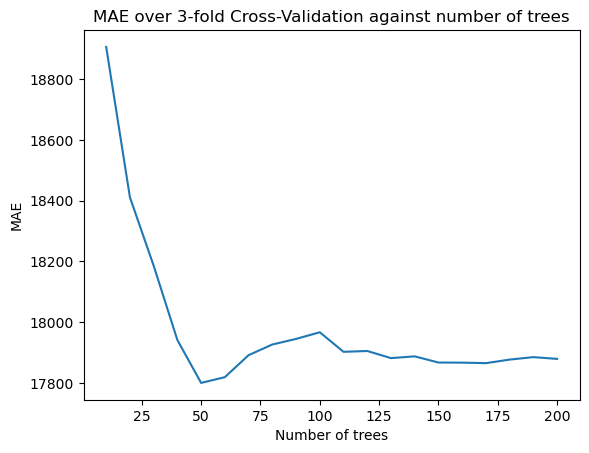

In [73]:
import matplotlib.pyplot as plt

plt.plot(no_trees, results)
plt.title("MAE over " + str(no_folds) + "-fold Cross-Validation against number of trees")
plt.xlabel("Number of trees")
plt.ylabel("MAE")

In [74]:
no_folds = 5
no_trees = []
results = []
for i in range(20):
    no_trees.append(30 * (1+i))
    print("Performing cross-validation for forest with " + str(no_trees[-1]) + " trees...")
    results.append(get_score(no_trees[-1], no_folds))

Performing cross-validation for forest with 30 trees...
Performing cross-validation for forest with 60 trees...
Performing cross-validation for forest with 90 trees...
Performing cross-validation for forest with 120 trees...
Performing cross-validation for forest with 150 trees...
Performing cross-validation for forest with 180 trees...
Performing cross-validation for forest with 210 trees...
Performing cross-validation for forest with 240 trees...
Performing cross-validation for forest with 270 trees...
Performing cross-validation for forest with 300 trees...
Performing cross-validation for forest with 330 trees...
Performing cross-validation for forest with 360 trees...
Performing cross-validation for forest with 390 trees...
Performing cross-validation for forest with 420 trees...
Performing cross-validation for forest with 450 trees...
Performing cross-validation for forest with 480 trees...
Performing cross-validation for forest with 510 trees...
Performing cross-validation for fo

Text(0, 0.5, 'MAE')

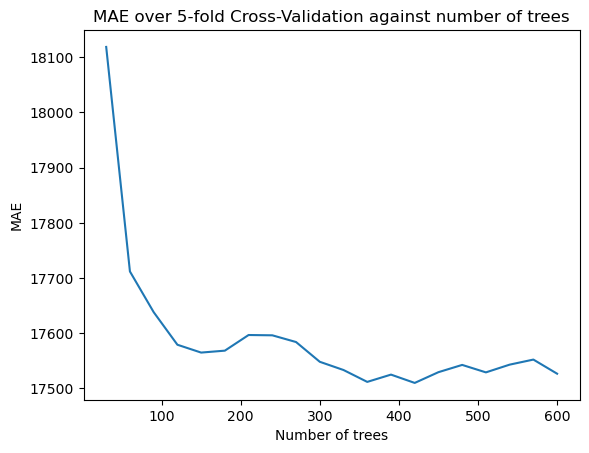

In [75]:
plt.plot(no_trees, results)
plt.title("MAE over " + str(no_folds) + "-fold Cross-Validation against number of trees")
plt.xlabel("Number of trees")
plt.ylabel("MAE")

Performing cross-validation for forest with 50 trees...
Performing cross-validation for forest with 100 trees...
Performing cross-validation for forest with 150 trees...
Performing cross-validation for forest with 200 trees...
Performing cross-validation for forest with 250 trees...
Performing cross-validation for forest with 300 trees...
Performing cross-validation for forest with 350 trees...
Performing cross-validation for forest with 400 trees...
Performing cross-validation for forest with 450 trees...
Performing cross-validation for forest with 500 trees...
Performing cross-validation for forest with 550 trees...
Performing cross-validation for forest with 600 trees...
Performing cross-validation for forest with 650 trees...
Performing cross-validation for forest with 700 trees...
Performing cross-validation for forest with 750 trees...
Performing cross-validation for forest with 800 trees...
Performing cross-validation for forest with 850 trees...
Performing cross-validation for 

Text(0, 0.5, 'MAE')

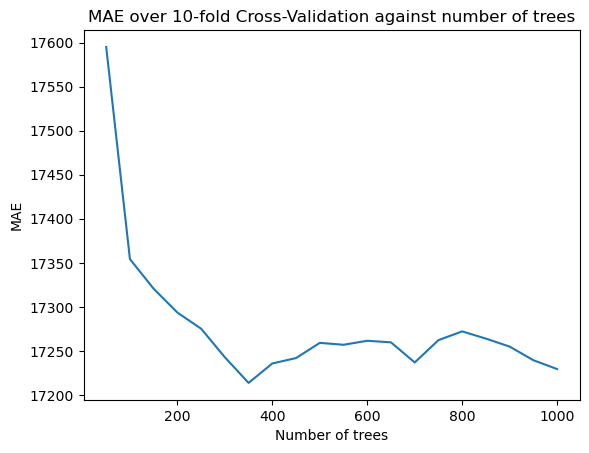

In [76]:
no_folds = 10
no_trees = []
results = []
for i in range(20):
    no_trees.append(50 * (1+i))
    print("Performing cross-validation for forest with " + str(no_trees[-1]) + " trees...")
    results.append(get_score(no_trees[-1], no_folds))

plt.plot(no_trees, results)
plt.title("MAE over " + str(no_folds) + "-fold Cross-Validation against number of trees")
plt.xlabel("Number of trees")
plt.ylabel("MAE")

It appears that the best performance is achieved for 350 trees in the random forest, and adding additional trees does not lead to much, if any, improvement.

## Gradient Boosting

Gradient boosting, or XGBoost, is a method of training ensemble methods, such as the random forests met above. An ensemble method is a set of models whose predictions are averaged over to form a final prediction. In the case of random forests we average over the prediction of multiple decision trees fitted to the data.

Up until now we have fitted all trees without consideration of the previously fitted ones. Instead, we could use information about the performance of previously fitted trees to perform better fits on future trees. In other words, we iteratively build up the ensemble of model. This is referred to a boosted ensemble, or in this case - a boosted decision tree. Gradient boosting refers to the use of gradient descent to determine the appropriate parameters model to add next to the ensemble.

In [77]:
from xgboost import XGBRegressor

In [92]:
full_data = pd.read_csv(iowa_train_data_dir, index_col = 'Id')
full_data_test = pd.read_csv(iowa_test_data_dir, index_col = 'Id')

full_data.dropna(axis = 0, subset=['SalePrice'], inplace=True)
y = full_data.SalePrice
X = full_data.drop(['SalePrice'], axis=1)

X_train, X_validate, y_train, y_validate = train_test_split(X, y, train_size = 0.8, test_size = 0.2, random_state=0)

# extract categorical columns with cardinality lower than 10
low_cardinality_categorical_cols = [col_name for col_name in X_train.columns if X_train[col_name].dtype == 'object' and X_train[col_name].nunique() < 10]

# extract numerical columns with no missing values
numerical_cols = [col_name for col_name in X_train.columns if X_train[col_name].dtype in ['int64', 'float64'] and X_train[col_name].isnull().sum() == 0]

all_cols = low_cardinality_categorical_cols + numerical_cols
X_train = X_train[all_cols].copy()
X_validate = X_validate[all_cols].copy()
X_test = full_data_test[all_cols].copy()

# one-hot encode the categorical data using pandas
X_train = pd.get_dummies(X_train)
X_validate = pd.get_dummies(X_validate)
X_test = pd.get_dummies(X_test)

print(X_train.shape)
print(X_validate.shape)
print(X_test.shape)

# add required one-hot encoded categorical columns to validation and testing datasets
X_train, X_validate = X_train.align(X_validate, join='left', axis=1)
X_train, X_test = X_train.align(X_test, join='left', axis=1)

print(X_train.shape)
print(X_validate.shape)
print(X_test.shape)

(1168, 224)
(292, 205)
(1459, 214)
(1168, 224)
(292, 224)
(1459, 224)


In [88]:
# default XGBoost model
model_1 = XGBRegressor(random_state=0)

model_1.fit(X_train, y_train)

predictions_validate_1 = model_1.predict(X_validate)
print('MAE for default XGBoost:', round(mean_absolute_error(y_validate, predictions_validate_1)))

MAE for default XGBoost: 18348


We will now see how we can improve the model by changing the number of estimators in the ensemble, or the learning rate.

In [94]:
def get_mae_xgboost(model, X_train = X_train, X_validate = X_validate, y_train = y_train, y_validate = y_validate):
    model.fit(X_train, y_train)
    predictions_validate = model.predict(X_validate)
    return mean_absolute_error(y_validate, predictions_validate)


In [106]:
all_mae_values = []

for i in range(10):
    learning_rate = 0.05 * (1+i)
    no_estimators = []
    mae_values = []
    for i in range(12):
        no_estimators.append(50 * (i+1))
        print("Finding MAE for gradient boosted forest with " + str(no_estimators[-1]) + " trees and a learning rate of " + str(learning_rate) + "...")
        tmp_model = XGBRegressor(random_state = 0, n_estimators = no_estimators[-1], learning_rate = learning_rate)
        mae_values.append(get_mae_xgboost(tmp_model))
    all_mae_values.append(mae_values)


Finding MAE for gradient boosted forest with 50 trees and a learning rate of 0.05...
Finding MAE for gradient boosted forest with 100 trees and a learning rate of 0.05...
Finding MAE for gradient boosted forest with 150 trees and a learning rate of 0.05...
Finding MAE for gradient boosted forest with 200 trees and a learning rate of 0.05...
Finding MAE for gradient boosted forest with 250 trees and a learning rate of 0.05...
Finding MAE for gradient boosted forest with 300 trees and a learning rate of 0.05...
Finding MAE for gradient boosted forest with 350 trees and a learning rate of 0.05...
Finding MAE for gradient boosted forest with 400 trees and a learning rate of 0.05...
Finding MAE for gradient boosted forest with 450 trees and a learning rate of 0.05...
Finding MAE for gradient boosted forest with 500 trees and a learning rate of 0.05...
Finding MAE for gradient boosted forest with 550 trees and a learning rate of 0.05...
Finding MAE for gradient boosted forest with 600 trees 

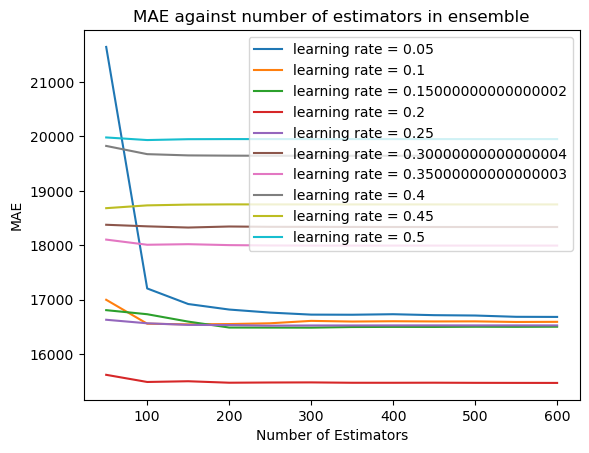

In [110]:
for i in range(10):
    learning_rate = 0.05 * (1+i)
    plt.plot(no_estimators, all_mae_values[i], label = "learning rate = " + str(learning_rate))
plt.title("MAE against number of estimators in ensemble")
plt.xlabel("Number of Estimators")
plt.ylabel("MAE")
plt.legend()

In [112]:
final_model = XGBRegressor(random_state = 0, n_estimators = 100, learning_rate = 0.2)

final_model.fit(X_train, y_train)
predictions_test = final_model.predict(X_test)

output = pd.DataFrame({'Id': X_test.index,
                       'SalePrice': predictions_test})
output.to_csv('submission_xgboost.csv', index=False)

## Data Leakage

Data leakage, or simply leakage, occurs when the data used to train the model contains information that will not be avaialble in the testing data, i.e., the data which the model will encounter in production. There are two main types of data leakage:
 * target leakage - the training dataset contains predictors which are highly correlated with the response variable, but have no causal effect on its outcome. For example, consider a model which predicts whether a patient has cancer or not. A variable which states whether the patient has undergone homeotherapy would only make sense for patients who have already been diagnosed with cancer. Hence, it will be highly correlated with the response, which will in turn lead to very good training accuracy. However, testing data will likely not have information about homeotherapy for the patients, and so the model will prbably perform quite badly.
 * train-test contamination - this occurs when the validation dataset has not been treated entirely separately from the training dataset. For instance, if we apply the initial preprocessing steps, such as encodings and imputation, to the full training plus validation datasets, we would expect good performance on the validation data. However, this will be misrepresentative of the true power of the model, since initial preprocessing should be applied first to the training dataset.